In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import numpy as np
from pathlib import Path
import json
import pickle
import re


from IPython.core.display import HTML
def print_df(df): display(HTML(df.to_html()))


dict_labels = {
    1024: '1k', 2048: '2k', 4096: '4k', 8192: '8k', 
    10240: '10k', 12288: '12k', 16000: '16k', 16384: '16k', 
    20480: '20k', 24000: '24k', 32000: '32k', 32768: '32k', 
    49000: '48k', 64000: '64k', 80000: '80k', 128000: '128k', 140000: '140k'}
def make_label(n_merges, init_vocab_size=186):
    n_merges_str = dict_labels.get(n_merges) if dict_labels.get(n_merges) else n_merges         
    vocab_size_final = init_vocab_size + n_merges
    ratio = vocab_size_final / init_vocab_size
    if ratio < 10:
        return '{}-(x {:.1f})'.format(n_merges_str, ratio)
    else:
        return '{}-(x {})'.format(n_merges_str, int(ratio))
        

In [3]:
def read_perfo(perfo_file, grouping, merge_data='auto'):
    config_file = os.path.join(perfo_file.parent, 'config.json')
    with open(config_file, 'r') as fp:
        config = json.load(fp)
    
    data = {
        'ckpt': perfo_file.parent.name,
        'tokenizer': perfo_file.parent.name.split('_')[0],
        'grouping': grouping,
    }
    if merge_data == 'auto':
        data['merges'] = 0 if not(perfo_file.parents[1].name).isdigit() else int(perfo_file.parents[1].name)
    elif merge_data == 'config':
        data['merges'] = config['bpe_merges']
    
    
    data['seed_split'] = config['seed_split']
    data['model_base'] = config.get('model_base')
    data['window_size'] = config.get('window_size')
    data['chunk_size'] = config.get('chunk_size')
    data['chunk_when'] = config.get('chunk_when')
    if grouping == 'sanity':
        data['grouping'] = f"sanity{config.get('sanity_split_frq')}"
    
    model_summary = config.get('model_summary')
    total_params = re.findall("Total params: .*\n", model_summary)
    total_params = int(total_params[0][:-1].replace('Total params:', '').replace(',', ''))
    data['params'] = total_params
        
    with open(perfo_file, 'r') as fp:
        data = dict(data.items(), **json.load(fp))
    
    data['path'] = perfo_file.parent
    return data

def get_perfo_model(model_path, merge_data='auto', VERBOSE=False):
    done = set()
    existing = set()
    perfos = []
    all_folders = set([str(f.parent) for f in Path(model_path).glob('**/*')])
    for json_file in Path(model_path).glob('**/*.json'):
        existing.add(str(json_file.parent))
        if json_file.stem == 'perfo':
            done.add(str(json_file.parent))
            if 'no_bpe' in str(json_file.parent):
                grouping = 'No BPE'
            elif 'with_bpe' in str(json_file.parent):
                grouping = 'With BPE'
            elif 'sanity' in str(json_file.parent):
                grouping = 'sanity'

            perfos.append(read_perfo(json_file, grouping, merge_data=merge_data))
    
    for x in sorted(all_folders):
        if x not in done and VERBOSE:
            print(f"Missing perfo: {x} : {len(list(Path(x).glob('*')))} files")
    return perfos

## Exp 231 (Phrase detection - Tf - Monophonic)

In [4]:
# Classif
model_path = "/mnt/nfs_share_magnet2/ldinhvie/tokenization_models/exp231_tf_clfdata"
perfos = get_perfo_model(model_path, merge_data='config', VERBOSE=False)

df_perfos = pd.DataFrame(perfos).sort_values(['tokenizer', 'merges', 'grouping', 'seed_split'])
df_perfos.head()

,ckpt,tokenizer,grouping,merges,seed_split,model_base,window_size,chunk_size,chunk_when,params,test_acc,test_recall,test_precision,test_macrof1,test_weightedf1,path,class1_f1,class1_precision,class1_recall
7,REMIVelocityMute_no_bpe_0_0701_0651,REMIVelocityMute,No BPE,0,0,BERT,None,512,None,1802755,0.992333,0.726639,0.898553,0.787618,0.979989,/mnt/nfs_share_magnet2/ldinhvie/tokenization_m...,0.584224,0.812070,0.456221
6,REMIVelocityMute_no_bpe_0_0701_0818,REMIVelocityMute,No BPE,0,1,BERT,None,512,None,1802755,0.992185,0.722500,0.897017,0.783783,0.979650,/mnt/nfs_share_magnet2/ldinhvie/tokenization_m...,0.576680,0.809237,0.447949
65,REMIVelocityMute_no_bpe_0_0701_0936,REMIVelocityMute,No BPE,0,2,BERT,None,512,None,1802755,0.992348,0.731095,0.895679,0.790532,0.980106,/mnt/nfs_share_magnet2/ldinhvie/tokenization_m...,0.590051,0.806134,0.465322
105,REMIVelocityMute_with_bpe_0702_0824,REMIVelocityMute,With BPE,8,0,BERT,None,512,None,1803779,0.990091,0.582910,0.983740,0.635067,0.962426,/mnt/nfs_share_magnet2/ldinhvie/tokenization_m...,0.284325,NaN,NaN
45,REMIVelocityMute_with_bpe_0702_0448,REMIVelocityMute,With BPE,16,0,BERT,None,512,None,1804675,0.990059,0.582500,0.981734,0.633507,0.957496,/mnt/nfs_share_magnet2/ldinhvie/tokenization_m...,0.283114,NaN,NaN


In [5]:
df_perf = df_perfos.loc[
    (df_perfos.tokenizer == 'REMIVelocityMute') 
    & (df_perfos.merges.isin([32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16000, 32000, 64000, 128000]))
].copy()
df_perf['label'] = df_perf.merges.apply(lambda x: make_label(x))

df_perf.groupby(['tokenizer', 'merges', 'grouping'])[['seed_split', 'test_macrof1']].agg(['mean', 'std'])

seed_split      test_macrof1          
                                       mean  std         mean       std
tokenizer        merges grouping                                       
REMIVelocityMute 32     With BPE        1.0  1.0     0.743998  0.019894
                 64     No BPE          1.0  1.0     0.741938  0.002230
                        With BPE        1.0  1.0     0.695600  0.007272
                 128    No BPE          1.0  1.0     0.717658  0.004824
                        With BPE        1.0  1.0     0.702629  0.025567
                 256    No BPE          1.0  1.0     0.731696  0.003206
                        With BPE        1.0  1.0     0.759967  0.004911
                 512    No BPE          1.0  1.0     0.743378  0.004213
                        With BPE        1.0  1.0     0.759624  0.013201
                 1024   No BPE          1.0  1.0     0.740741  0.001707
                        With BPE        1.0  1.0     0.756781  0.009764
                 2048   No BPE          1.0  1.0     0.744933  0.006405
                        With BPE        1.0  1.0     0.767649  0.000849
                 4096   No BPE          1.0  1.0     0.735979  0.000976
                        With BPE        1.0  1.0     0.770902  0.006318
                 8192   No BPE          0.0  NaN     0.727610       NaN
                        With BPE        1.0  1.0     0.775850  0.003148
                 16000  With BPE        1.0  1.0     0.777376  0.001594
                 32000  With BPE        1.0  1.0     0.766073  0.003693
                 64000  With BPE        1.0  1.0     0.746527  0.004584
                 128000 With BPE        1.0  1.0     0.721816  0.005814

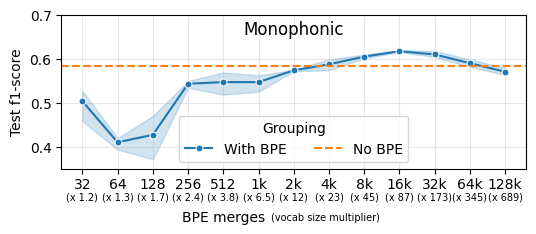

In [6]:
plt.figure(figsize=(6, 2))
palette = [sns.color_palette("colorblind", as_cmap=True)[x] for x in [0, 4]]
df_perfo_bpe_only = df_perf.loc[df_perf.grouping == 'With BPE']
fig = sns.lineplot(data=df_perfo_bpe_only, x="label", y="class1_f1", label='With BPE', marker="o", markersize=5)
# fig = sns.barplot(data=df_perfo_bpe_only, x="label", y="class1_f1", edgecolor=(1,1,1,0.5), capsize=.2, err_kws={'linewidth':1}, label='With BPE')

zero_perf = df_perfos.loc[df_perfos.merges == 0].class1_f1.mean()
plt.axhline(zero_perf, linestyle='--', color='tab:orange', label='No BPE')

fig.legend(loc=8, title='Grouping', ncol=2) # loc='center left', bbox_to_anchor=(1, 0.5), 
plt.grid('both', alpha=0.3)

plt.ylabel('Test f1-score')
plt.ylim(bottom=0.35, top=0.7)

for tick in plt.gca().get_xticklabels():
    plt.text(tick.get_position()[0], tick.get_position()[1]+0.30, tick.get_text().split('-')[0], horizontalalignment='center', verticalalignment='bottom')
    plt.text(tick.get_position()[0], tick.get_position()[1]+0.275, tick.get_text().split('-')[1], horizontalalignment='center', verticalalignment='bottom', fontsize=7)

plt.text(4, 0.24, 'BPE merges', horizontalalignment='center', verticalalignment='center')
plt.text(6.9, 0.24, '(vocab size multiplier)', horizontalalignment='center', verticalalignment='center', fontsize=7)

fig.set_xticklabels([])
plt.xlabel('')
fig.set_title('Monophonic', y=1.0, pad=-14)


plt.savefig('figures/exp231_clfdata_onlybpe_f1class1.pdf', bbox_inches='tight')

Export data

In [7]:
list_perfo_bpe = []
mean_values = df_perfo_bpe_only.groupby('merges')['class1_f1'].mean('numeric_only').to_dict()
std_values = df_perfo_bpe_only.groupby('merges')['class1_f1'].std().to_dict()

stats = df_perfo_bpe_only.groupby(['merges'], as_index=False)['class1_f1'].agg(['mean', 'sem'])
stats['ci95'] = 1.96* stats['sem']
stats['ci95_hi'] = stats['mean'] + 1.96* stats['sem']
stats['ci95_lo'] = stats['mean'] - 1.96* stats['sem']


for ii, ((merges, mean), (_, std)) in enumerate(zip(mean_values.items(), std_values.items())):
    ci_stats = stats.loc[stats.merges == merges]
    assert len(ci_stats) == 1
    
    label_full = df_perfo_bpe_only.loc[df_perfo_bpe_only.merges == merges].iloc[0]['label']
    label, vocab_size_mult = label_full.split('-')
    # label = label + "\\\\" + "{{\\tiny{}}}".format(vocab_size_mult)
    label = "{" + label + "\\\\[-2pt]" + "{{\\tinier{}}}".format(vocab_size_mult) + "}"
    list_perfo_bpe.append({
        'x': ii,
        'label': label,
        'merges': merges,
        'f1_score_mean': mean,
        'f1_score_std': std,
        'f1_score_std_up': mean + std,
        'f1_score_std_low': mean - std,
        'f1_score_ci': ci_stats.iloc[0]['ci95'],
        'f1_score_ci95_up': ci_stats.iloc[0]['ci95_hi'],
        'f1_score_ci95_low': ci_stats.iloc[0]['ci95_lo'],
    })
pd.DataFrame(list_perfo_bpe).to_csv('plot_data/perfo_monophonic.csv', index=False)
pd.DataFrame([{'x': -100, 'zero_perf': zero_perf}, {'x': 100, 'zero_perf': zero_perf}]).to_csv('plot_data/perfo_monophonic_zero.csv', index=False)

## Exp 232 (Phrase  detection - Tf - Polyphonic)

In [8]:
# Classif
model_path = "/mnt/nfs_share_magnet2/ldinhvie/tokenization_models/exp232_tf_clfdata"
perfos = get_perfo_model(model_path, merge_data='config', VERBOSE=False)

df_perfos = pd.DataFrame(perfos).sort_values(['tokenizer', 'chunk_when', 'merges', 'grouping', 'seed_split'])
# print_df(df_perfos)
df_perfos.head()

,ckpt,tokenizer,grouping,merges,seed_split,model_base,window_size,chunk_size,chunk_when,params,test_acc,test_recall,test_precision,test_macrof1,test_weightedf1,class1_f1,class1_precision,class1_recall,path
83,REMIVelocityMute_with_bpe_0701_1534,REMIVelocityMute,With BPE,64,0,BERT,None,512,after,1810947,0.993373,0.575105,0.987920,0.627981,0.987098,0.260719,NaN,NaN,/mnt/nfs_share_magnet2/ldinhvie/tokenization_m...
81,REMIVelocityMute_with_bpe_0701_1543,REMIVelocityMute,With BPE,64,1,BERT,None,512,after,1810947,0.993369,0.574060,0.990351,0.626473,0.987033,0.257718,NaN,NaN,/mnt/nfs_share_magnet2/ldinhvie/tokenization_m...
82,REMIVelocityMute_with_bpe_0701_1544,REMIVelocityMute,With BPE,64,2,BERT,None,512,after,1810947,0.993356,0.573985,0.985631,0.626212,0.987044,0.257196,NaN,NaN,/mnt/nfs_share_magnet2/ldinhvie/tokenization_m...
69,REMIVelocityMute_with_bpe_0701_1530,REMIVelocityMute,With BPE,128,0,BERT,None,512,after,1819267,0.992850,0.574656,0.988561,0.627058,0.985544,0.259446,0.987702,0.149336,/mnt/nfs_share_magnet2/ldinhvie/tokenization_m...
71,REMIVelocityMute_with_bpe_0702_0000,REMIVelocityMute,With BPE,128,1,BERT,None,512,after,1819267,0.992850,0.574695,0.989736,0.627155,0.985552,0.259635,0.990049,0.149408,/mnt/nfs_share_magnet2/ldinhvie/tokenization_m...


In [9]:
df_perf = df_perfos.loc[
    # (df_perfos.tokenizer == 'REMIVelocityMute') & (df_perfos.chunk_when == 'before') & \
    (df_perfos.tokenizer == 'REMIVelocityMute') & (((df_perfos.chunk_when == 'after') & (df_perfos.grouping == 'With BPE')) | ((df_perfos.chunk_when == 'before') & (df_perfos.grouping == 'No BPE'))) &\
    (df_perfos.merges.isin([128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768, 64000, 128000]))
].copy()
df_perf['label'] = df_perf.merges.apply(lambda x: make_label(x))
df_perf.groupby(['tokenizer', 'merges', 'grouping'])[['seed_split', 'test_macrof1']].agg(['mean', 'std'])

seed_split           test_macrof1          
                                       mean       std         mean       std
tokenizer        merges grouping                                            
REMIVelocityMute 128    With BPE   1.000000  1.000000     0.627100  0.000049
                 256    With BPE   1.000000  1.000000     0.631796  0.000258
                 512    With BPE   1.000000  1.000000     0.634046  0.003410
                 1024   No BPE     0.000000       NaN     0.706401       NaN
                        With BPE   1.250000  0.957427     0.644572  0.001589
                 2048   No BPE     1.000000  1.000000     0.680785  0.010596
                        With BPE   1.000000  1.000000     0.651587  0.005428
                 4096   With BPE   1.000000  1.000000     0.654497  0.007685
                 8192   No BPE     1.000000  1.000000     0.672701  0.002133
                        With BPE   1.000000  1.000000     0.655158  0.001675
                 16384  No BPE     1.000000  1.000000     0.666384  0.002484
                        With BPE   1.000000  1.000000     0.650148  0.007234
                 32768  No BPE     1.000000  1.000000     0.663326  0.003593
                        With BPE   1.000000  1.000000     0.654952  0.001836
                 64000  No BPE     1.000000  1.000000     0.658797  0.001747
                        With BPE   1.000000  1.000000     0.660649  0.004645
                 128000 With BPE   1.333333  1.154701     0.661202  0.002307

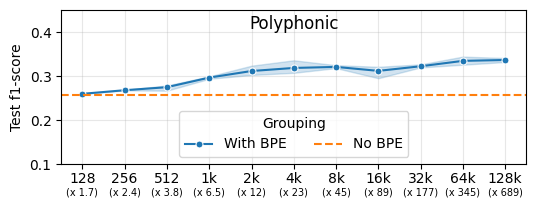

In [10]:
plt.figure(figsize=(6, 2))
palette = [sns.color_palette("colorblind", as_cmap=True)[x] for x in [0, 4]]
df_perfo_bpe_only = df_perf.loc[df_perf.grouping == 'With BPE']
fig = sns.lineplot(data=df_perfo_bpe_only, x="label", y="class1_f1", label='With BPE', marker="o", markersize=5)
# fig = sns.barplot(data=df_perfo_bpe_only, x="label", y="class1_f1", edgecolor=(1,1,1,0.5), capsize=.2, err_kws={'linewidth':1}, label='With BPE')

zero_perf = df_perfos.loc[df_perfos.merges == 0].class1_f1.mean()
plt.axhline(zero_perf, linestyle='--', color='tab:orange', label='No BPE')
2
fig.legend(loc=8, title='Grouping', ncol=2) # loc='center left', bbox_to_anchor=(1, 0.5), 
plt.grid('both', alpha=0.3)

plt.ylabel('Test f1-score')
plt.ylim(bottom=0.1, top=0.45)

for tick in plt.gca().get_xticklabels():
    plt.text(tick.get_position()[0], tick.get_position()[1]+0.05, tick.get_text().split('-')[0], horizontalalignment='center', verticalalignment='bottom')
    plt.text(tick.get_position()[0], tick.get_position()[1]+0.025, tick.get_text().split('-')[1], horizontalalignment='center', verticalalignment='bottom', fontsize=7)

# plt.text(4, -0.015, 'BPE merges', horizontalalignment='center', verticalalignment='center')
# plt.text(6.4, -0.015, '(vocab size multiplier)', horizontalalignment='center', verticalalignment='center', fontsize=7)

fig.set_xticklabels([])
plt.xlabel('')
fig.set_title('Polyphonic', y=1.0, pad=-14)


plt.savefig('figures/exp232_clfdata_onlybpe_f1class1.pdf', bbox_inches='tight')

Export data

In [11]:
list_perfo_bpe = []
mean_values = df_perfo_bpe_only.groupby('merges')['class1_f1'].mean('numeric_only').to_dict()
std_values = df_perfo_bpe_only.groupby('merges')['class1_f1'].std().to_dict()

stats = df_perfo_bpe_only.groupby(['merges'], as_index=False)['class1_f1'].agg(['mean', 'sem'])
stats['ci95'] = 1.96* stats['sem']
stats['ci95_hi'] = stats['mean'] + 1.96* stats['sem']
stats['ci95_lo'] = stats['mean'] - 1.96* stats['sem']


for ii, ((merges, mean), (_, std)) in enumerate(zip(mean_values.items(), std_values.items())):
    ci_stats = stats.loc[stats.merges == merges]
    assert len(ci_stats) == 1
    
    label_full = df_perfo_bpe_only.loc[df_perfo_bpe_only.merges == merges].iloc[0]['label']
    label, vocab_size_mult = label_full.split('-')
    # label = label + "\\\\" + "{{\\tiny{}}}".format(vocab_size_mult)
    label = "{" + label + "\\\\[-2pt]" + "{{\\tinier{}}}".format(vocab_size_mult) + "}"
    list_perfo_bpe.append({
        'x': ii,
        'label': label,
        'merges': merges,
        'f1_score_mean': mean,
        'f1_score_std': std,
        'f1_score_std_up': mean + std,
        'f1_score_std_low': mean - std,
        'f1_score_ci': ci_stats.iloc[0]['ci95'],
        'f1_score_ci95_up': ci_stats.iloc[0]['ci95_hi'],
        'f1_score_ci95_low': ci_stats.iloc[0]['ci95_lo'],
    })
pd.DataFrame(list_perfo_bpe).to_csv('plot_data/perfo_polyphonic.csv', index=False)
pd.DataFrame([{'x': -100, 'zero_perf': zero_perf}, {'x': 100, 'zero_perf': zero_perf}]).to_csv('plot_data/perfo_polyphonic_zero.csv', index=False)

## Ratio Pitch in supertokens

In [12]:
with open('results/mtcpiano_by_types_save.pickle', 'rb') as f:
    results_piano = pickle.load(f)
norm_all_count_pitches_piano = results_piano['pitches'] / results_piano['norm_matrix']

with open('results/mtcmono_by_types_save.pickle', 'rb') as f:
    results_mono = pickle.load(f)
norm_all_count_pitches_mono = results_mono['pitches'] / results_mono['norm_matrix']

/tmp/ipykernel_257987/67211102.py:3: RuntimeWarning: invalid value encountered in divide
  norm_all_count_pitches_piano = results_piano['pitches'] / results_piano['norm_matrix']
/tmp/ipykernel_257987/67211102.py:7: RuntimeWarning: invalid value encountered in divide
  norm_all_count_pitches_mono = results_mono['pitches'] / results_mono['norm_matrix']


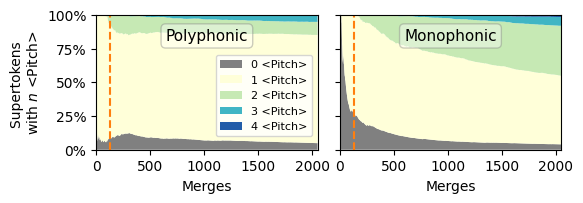

In [13]:
x_max = 2048
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 1.75), sharey=True)

# cmap = plt.get_cmap("tab10")
# palette = ["gray"] + [cmap[i % 6] for i in range(0, 100)]
cmap = sns.color_palette("YlGnBu", as_cmap=True)
palette = ['gray'] + [cmap(i) for i in np.linspace(0, 1, 5)]
# palette = matplotlib.colors.ListedColormap(palette)

# ax1.stackplot(np.arange(x_max), results_piano['pitches'][:x_max].T, labels=[f'{x} <Pitch>' for x in range(5)], colors=palette)
# ax2.stackplot(np.arange(x_max), results_mono['pitches'][:x_max].T, labels=[f'{x} <Pitch>' for x in range(6)], colors=palette)
ax1.stackplot(np.arange(x_max), norm_all_count_pitches_piano[:x_max].T, labels=[f'{x} <Pitch>' for x in range(5)], colors=palette)
ax2.stackplot(np.arange(x_max), norm_all_count_pitches_mono[:x_max].T, labels=[f'{x} <Pitch>' for x in range(6)], colors=palette)

ax1.legend(fontsize=8, loc='center right', bbox_to_anchor=(1, 0.4))
# ax2.legend(fontsize=8, loc=5)
ax1.set_xlim([0, x_max])
ax2.set_xlim([0, x_max])
ax1.set_ylim([0, 1])
ax2.set_ylim([0, 1])
ax1.set_ylabel('Supertokens \nwith $n$ <Pitch>')
# ax2.set_ylabel('Supertokens \nwith $n$ <Pitch>')
ax1.set_xlabel('Merges')
ax2.set_xlabel('Merges')

ax1.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))

ax1.text(1024, 0.9, 'Polyphonic', 
        fontsize=11,
        horizontalalignment='center',
        verticalalignment='top',
        color='black', 
        bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round', alpha=0.4))

ax2.text(1024, 0.9, 'Monophonic', 
        fontsize=11,
        horizontalalignment='center',
        verticalalignment='top',
        color='black', 
        bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round', alpha=0.4))

ax1.axvline(128,  linestyle='--', color='tab:orange')
ax2.axvline(128,  linestyle='--', color='tab:orange')

plt.subplots_adjust(wspace=.1)
plt.savefig('figures/ratio_pitch_supertokens.pdf', bbox_inches='tight',dpi=1)

Export data

In [14]:
max_pitches = 10
dict_data_poly = {'x': np.arange(x_max)}
dict_data_mono = {'x': np.arange(x_max)}
for n_pitches in range(max_pitches):
    dict_data_poly[f"p{n_pitches}"] = norm_all_count_pitches_piano[:x_max].T[n_pitches]
    dict_data_mono[f"p{n_pitches}"] = norm_all_count_pitches_mono[:x_max].T[n_pitches]

pd.DataFrame(dict_data_poly).bfill().to_csv('plot_data/ratio_pitch_supertokens_poly.csv', index=False)
pd.DataFrame(dict_data_mono).bfill().to_csv('plot_data/ratio_pitch_supertokens_mono.csv', index=False)

## Music-BPE vs. Text-BPE

In [15]:
sys.path.append('./src')

from miditok import REMI, Octuple, Structured, CPWord, bpe
from miditoolkit import MidiFile
from src.tokenizer import *

In [16]:
TokenizerClass = REMIVelocityMute
tokenizer_name = TokenizerClass.__name__
n_merges = 4096
nb_velocities = 1

def tokenizer_returner():
    return TokenizerClass(nb_velocities=1, include_first_note=False)

In [17]:
def learn_bpe_return_tokenizer(train_data_path, train_tokenized_data_path, train_tokenized_bpe_data_path, n_merges):
    print(train_data_path)
    
    tokenizer = bpe(TokenizerClass, nb_velocities=1)
    tokenizer_name = tokenizer.__class__.__bases__[0].__name__
    print(tokenizer_name)
    
    midi_paths = list(Path(*train_data_path).glob('**/*.mid'))
    tokenizer.tokenize_midi_dataset(midi_paths, Path(*train_tokenized_data_path))

    tokenizer.bpe(
        tokens_path=Path(*train_tokenized_data_path), 
        n_merges=n_merges,
        out_dir=Path(*train_tokenized_bpe_data_path), 
        files_lim=None
    )
    
    return tokenizer

def compute_length_corpus_midi(train_data_path, tokenizer_returner):
    length_corpus = 0
    files_list = list(Path(*train_data_path).glob('**/*.mid'))
    for midi_file in tqdm(files_list, leave=False, position=1):
        # print(midi_file)
        tokenizer = tokenizer_returner()
        midi = MidiFile(midi_file)
        tokens = tokenizer.midi_to_tokens(midi)[0]
        length_corpus += len(tokens)
    
    return length_corpus


def make_df_music_bpe_tokens(tokenizer):
    list_bpe_tokens = []
    for token in tokenizer.vocab._token_to_event:
        frmt_token = tokenizer.vocab._token_to_event[token]
        if tokenizer.vocab.token_type(token) == 'BPE':
            frmt_root_events = convert_bpe_to_sequence_frmt(tokenizer, frmt_token)
            list_bpe_tokens.append({
                'index': token,
                'elementary': frmt_root_events
            })
            
    df_bpe_tokens = pd.DataFrame(list_bpe_tokens)
    df_bpe_tokens['length'] = df_bpe_tokens.elementary.apply(len)
    df_bpe_tokens['avg_until'] = [np.mean(df_bpe_tokens.length.iloc[:ii]) for ii in range(len(df_bpe_tokens))]
    df_bpe_tokens['max_until'] = [np.max(df_bpe_tokens.length.iloc[:ii]) for ii in range(len(df_bpe_tokens))]
    return df_bpe_tokens


def make_df_text_bpe_tokens(supertokens):
    df_bpe_tokens = pd.DataFrame({
        'supertokens': supertokens
    })
    df_bpe_tokens['length'] = df_bpe_tokens.supertokens.apply(len)
    df_bpe_tokens['avg_until'] = [np.mean(df_bpe_tokens.length.iloc[:ii]) for ii in range(len(df_bpe_tokens))]
    df_bpe_tokens['max_until'] = [np.max(df_bpe_tokens.length.iloc[:ii]) for ii in range(len(df_bpe_tokens))]
    return df_bpe_tokens


def read_json(filename):
    with open(filename) as f:
        content = json.load(f)
    return content

In [18]:
def tokenizer_returner():
    if "Interval" not in tokenizer_name:
        return TokenizerClass(nb_velocities=nb_velocities)
    else:
        return TokenizerClass(nb_velocities=nb_velocities, include_first_note=False)

tokenizer_folk = bpe(TokenizerClass, nb_velocities=nb_velocities)
tokenizer_piano = bpe(TokenizerClass, nb_velocities=nb_velocities)
tokenizer_quartets = bpe(TokenizerClass, nb_velocities=nb_velocities)
tokenizer_orchestra = bpe(TokenizerClass, nb_velocities=nb_velocities)

tokenizer_folk.load_params(Path(f"results/compare_text_music/{n_merges}/{tokenizer_name}/folk_reduce.bpe"))
tokenizer_piano.load_params(Path(f"results/compare_text_music/{n_merges}/{tokenizer_name}/piano.bpe"))
tokenizer_quartets.load_params(Path(f"results/compare_text_music/{n_merges}/{tokenizer_name}/quartets.bpe"))
tokenizer_orchestra.load_params(Path(f"results/compare_text_music/{n_merges}/{tokenizer_name}/orchestra.bpe"))

tokenizer_folk.supertoken_frq = torch.load(f"results/compare_text_music/{n_merges}/{tokenizer_name}/folk_reduce.frq")
tokenizer_piano.supertoken_frq = torch.load(f"results/compare_text_music/{n_merges}/{tokenizer_name}/piano.frq")
tokenizer_quartets.supertoken_frq = torch.load(f"results/compare_text_music/{n_merges}/{tokenizer_name}/quartets.frq")
tokenizer_orchestra.supertoken_frq = torch.load(f"results/compare_text_music/{n_merges}/{tokenizer_name}/orchestra.frq")

length_folk = read_json(f"results/compare_text_music/{n_merges}/{tokenizer_name}/folk_reduce.length")['corpus_length']
length_piano = read_json(f"results/compare_text_music/{n_merges}/{tokenizer_name}/piano.length")['corpus_length']
length_quartets = read_json(f"results/compare_text_music/{n_merges}/{tokenizer_name}/quartets.length")['corpus_length']
length_orchestra = read_json(f"results/compare_text_music/{n_merges}/{tokenizer_name}/orchestra.length")['corpus_length']

tokenizer_folk_pitchonly = bpe(PitchOnly, nb_velocities=nb_velocities)
tokenizer_folk_pitchonly.load_params(Path(f"results/compare_text_music/{n_merges}/PitchOnly/folk_reduce.bpe"))
tokenizer_folk_pitchonly.supertoken_frq = torch.load(f"results/compare_text_music/{n_merges}/PitchOnly/folk_reduce.frq")
length_folk_pitchonly = read_json(f"results/compare_text_music/{n_merges}/PitchOnly/folk_reduce.length")['corpus_length']

tokenizer_quartet_mono = bpe(PitchOnly, nb_velocities=nb_velocities)
tokenizer_quartet_mono.load_params(Path(f"results/compare_text_music/{n_merges}/REMIVelocityMute/quartets_track.bpe"))
tokenizer_quartet_mono.supertoken_frq = torch.load(f"results/compare_text_music/{n_merges}/REMIVelocityMute/quartets_track.frq")
length_quartet_mono = read_json(f"results/compare_text_music/{n_merges}/REMIVelocityMute/quartets_track.length")['corpus_length']

tokenizer_quartet_pitchonly = bpe(PitchOnly, nb_velocities=nb_velocities)
tokenizer_quartet_pitchonly.load_params(Path(f"results/compare_text_music/{n_merges}/PitchOnly/quartets_track.bpe"))
tokenizer_quartet_pitchonly.supertoken_frq = torch.load(f"results/compare_text_music/{n_merges}/PitchOnly/quartets_track.frq")
length_quartet_pitchonly = read_json(f"results/compare_text_music/{n_merges}/PitchOnly/quartets_track.length")['corpus_length']


mega_bpe_poly = bpe(TokenizerClass, nb_velocities=nb_velocities)
mega_bpe_poly.load_params(Path(f"bpe_tokenizers/REMIVelocityMute_128000_mtcpiano.bpe"))
length_mega_bpe_poly = 13_611_352 # polyphonic synth

mega_bpe_mono = bpe(TokenizerClass, nb_velocities=nb_velocities)
mega_bpe_mono.load_params(Path(f"bpe_tokenizers/REMIVelocityMute_128000_mtcmono.bpe"))
length_mega_bpe_mono = 4_158_308 # monophonic 

In [19]:
list_plots = [
    {
        'tokenizer': tokenizer_folk,
        'y': np.array(list(tokenizer_folk.supertoken_frq.values())),
        'length': length_folk,
        'label': '[REMI] folk',
        'style': '--',
        'type': 'music',
    },
    {
        'tokenizer': tokenizer_piano,
        'y': np.array(list(tokenizer_piano.supertoken_frq.values())),
        'length': length_piano,
        'label': '[REMI] piano',
        'style': '--',
        'type': 'music',
    },
    {
        'tokenizer': tokenizer_quartets,
        'y': np.array(list(tokenizer_quartets.supertoken_frq.values())),
        'length': length_quartets,
        'label': '[REMI] quartets',
        'style': '--',
        'type': 'music',
    },
    {
        'tokenizer': tokenizer_orchestra,
        'y': np.array(list(tokenizer_orchestra.supertoken_frq.values())),
        'length': length_orchestra,
        'label': '[REMI] orchestra',
        'style': '--',
        'type': 'music',
    },
    {
        'tokenizer': tokenizer_folk_pitchonly,
        'y': np.array(list(tokenizer_folk_pitchonly.supertoken_frq.values())),
        'length': length_folk_pitchonly,
        'label': '[PitchOnly] folk',
        'style': '-.',
        'type': 'music',
    },
    {
        'supertokens': np.load(f'results/compare_text_music/{n_merges}/xnli_en_supertokens.npy'),
        'y': np.load(f'results/compare_text_music/{n_merges}/xnli_en_frq.npy'),
        'metadata': read_json('results/compare_text_music/xnli_en_metadata.json'),
        'label': '[text] english',
        'style': '-',
        'type': 'text',
        'color': 'tab:brown',
    },
    {
        'supertokens': np.load(f'results/compare_text_music/{n_merges}/xnli_sw_supertokens.npy'),
        'y': np.load(f'results/compare_text_music/{n_merges}/xnli_sw_frq.npy'),
        'metadata': read_json('results/compare_text_music/xnli_sw_metadata.json'),
        'label': '[text] swedish',
        'style': '-',
        'type': 'text',
    },
    {
        'supertokens': np.load(f'results/compare_text_music/{n_merges}/xnli_vi_supertokens.npy'),
        'y': np.load(f'results/compare_text_music/{n_merges}/xnli_vi_frq.npy'),
        'metadata': read_json('results/compare_text_music/xnli_vi_metadata.json'),
        'label': '[text] vietnamese',
        'style': '-',
        'type': 'text',
    },
]

[REMI] folk >> Size 1,609,628 >> 6.390869140625
[REMI] piano >> Size 1,463,173 >> 3.44970703125
[REMI] quartets >> Size 1,390,859 >> 3.33447265625
[REMI] orchestra >> Size 1,134,449 >> 3.88427734375
[PitchOnly] folk >> Size 500,243 >> 6.025634765625


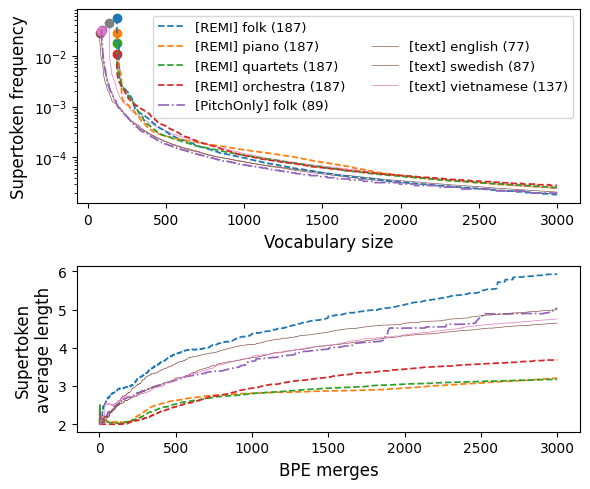

In [20]:
max_x = 3000
fig, (ax1, ax2) = plt.subplots(
    nrows=2, ncols=1, figsize=(6, 5), 
    gridspec_kw={
        'width_ratios': [1],
        'height_ratios': [2, 1.7],
    })
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)

supertoken_frq_export = []
supertoken_length_export = []

for data in list_plots:
    # Graph frq
    if data['type'] == 'text':
        y = data['y'] / data['metadata']['length_characters']
        init_size_vocab = data['metadata']['size_vocab'] 
        x = np.arange(init_size_vocab, init_size_vocab + len(y))
    else:
        print(f"{data['label']} >> Size {data['length']:,}", end=" >> ")
        y = data['y'] / data['length']
        if 'PitchOnly' in data['label']:
            init_size_vocab = len(PitchOnly().vocab)
        else:
            init_size_vocab = len(tokenizer_returner())
        x = np.arange(init_size_vocab, init_size_vocab+len(y))
    
    # print(f"{data['label']} >> Init vocab ({x[0]}, {y[0]})")
    
    if np.min(x) > max_x: continue
    
    max_index = np.where(x == max_x)[0][0] if len(np.where(x == max_x)[0]) > 0 else -1
    x = x[0:max_index]
    y = y[0:max_index]
    
    linewidth = 1.25 if data['type'] == 'music' else .5
    # linewidth = 2 if 'folk' in data['label'] else linewidth
    if data.get('color'):
        p = ax1.plot(
            x, y, label="{} ({})".format(data['label'], init_size_vocab), 
            linestyle=data['style'], 
            zorder=400 if data['type'] == 'music' else 0, 
            linewidth=linewidth, color=data['color']
        )
    else:
        p = ax1.plot(
            x, y, label="{} ({})".format(data['label'], init_size_vocab), 
            linestyle=data['style'], 
            zorder=400 if data['type'] == 'music' else 0, 
            linewidth=linewidth
        )
        
    supertoken_frq_export.append({
        'label': data['label'],
        'init_vocab_size': init_size_vocab,
        'x': x,
        'y': y,
    })
    
    # add scatter points
    # indexes = np.arange(0, 50, 10).tolist() + np.arange(100, len(y), 100).tolist()
    # ax1.plot(
    #     x[indexes], y[indexes],
    #     linestyle='none', marker='.', markersize=3, 
    #     color=p[0].get_color()
    # )
    
    ax1.scatter(x[0], [y[0]])
    
    # Graph length
    if data['type'] == 'music':
        df_bpe_tokens = make_df_music_bpe_tokens(data['tokenizer'])
        print(df_bpe_tokens.avg_until.iloc[-1])
    else:
        df_bpe_tokens = make_df_text_bpe_tokens(data['supertokens'])
    
    df_bpe_tokens = df_bpe_tokens.iloc[0:max_x]
    if data.get('color'):
        ax2.plot(
            df_bpe_tokens.avg_until, 
            linestyle=data['style'], 
            linewidth=linewidth,
            color=data['color']
        )
    else:
        ax2.plot(
            df_bpe_tokens.avg_until, 
            linestyle=data['style'], 
            linewidth=linewidth
        )

    supertoken_length_export.append({
        'label': data['label'],
        'x': np.arange(len(df_bpe_tokens.avg_until)),
        'y': list(df_bpe_tokens.avg_until),
    })

fontsize = 12
ax1.set_yscale('log')
ax1.set_ylabel('Supertoken frequency', fontsize=fontsize)
ax1.set_xlabel('Vocabulary size', fontsize=fontsize)

ax2.set_ylabel('Supertoken\naverage length', fontsize=fontsize)
ax2.set_xlabel('BPE merges', fontsize=fontsize)

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

# Add empty slot in first column
lines.insert(5, plt.Line2D([0], [0], linestyle='none', marker='none'))
labels.insert(5, '')


legend = ax1.legend(lines, labels, loc='upper right', ncol=2, prop={'size': 9.5})

for tt in legend.get_texts():
    if 'random' in tt.get_text():
        tt.set_fontstyle("italic")
        tt.set_fontsize(8.5)

plt.tight_layout()
plt.savefig('figures/bpe_text_music.pdf', bbox_inches='tight', pad_inches=0)

In [21]:
for item in supertoken_frq_export:
    key = item['label'].replace(' ', '_')
    df_item = pd.DataFrame({'vocab_size': item['x'], 'frq': item['y']})
    df_init_vocab_size = pd.DataFrame([{'init_vocab_size': item['init_vocab_size']}])
    df_item.to_csv(f'plot_data/{key}-supertoken_frq.csv', index=False)
    df_init_vocab_size.to_csv(f'plot_data/{key}-vocab_init_size.csv', index=False)
    
for item in supertoken_length_export:
    key = item['label'].replace(' ', '_')
    df_item = pd.DataFrame({'bpe_merges': item['x'], 'length': item['y']})
    df_item.to_csv(f'plot_data/{key}-supertoken_length.csv', index=False)
    